In [1]:
import openai
from PIL import Image
import numpy as np
import pandas as pd
import os
import sys
import requests
import base64
from io import BytesIO
import json
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple, Union

sys.path.insert(0, os.path.abspath("../"))

In [2]:
from mrcad.design import Design
from mrcad.env import MakerObservation
from mrcad.env_utils import Role
from mrcad.agents import AbstractMakerAgent
from mrcad.action import Action, Drawing
from experiments.data_conversion_utils import get_design_from_record, get_strokes_from_record, executeActions
from agents.gpt4_agents import GPT4DesignEditorAgent, GPT4DesignMakerAgent
from agents.editing_actions import EditingAction

In [3]:
instructions_df = pd.read_csv("../tests/df_instructions_mcad-async-internal-pilot-go.csv")
executions_df = pd.read_csv("../tests/df_executions_mcad-async-internal-pilot-go.csv")

In [4]:
data = []
for i, row in executions_df.iterrows():
    context = eval(row.context)
    current_design = get_design_from_record(executeActions(context['prevActions'])[0])
    action = Action(Role.DESIGNER, (context['text'], Drawing(get_strokes_from_record(context['strokes']))), None)
    new_design = get_design_from_record(executeActions(eval(row.actions))[0])
    data.append((row.targetId, row.generation, current_design, action, new_design))

In [5]:
data.sort(key=lambda x: (x[0], x[1]))

In [6]:
demonstrations = [(current_design, action, new_design) for _, _, current_design, action, new_design in data[:3]]

In [7]:
keys = {}
with open("../api_keys.txt") as f:
    for line in f:
        api, key = line.strip().split(" ")
        keys[api] = key

In [8]:
gpt4_agent = GPT4DesignEditorAgent(api_key=keys["openai"], max_tokens=512, temperature=0)

In [13]:
output = gpt4_agent.act(MakerObservation(data[3][2], data[3][3].instruction, Role.MAKER))

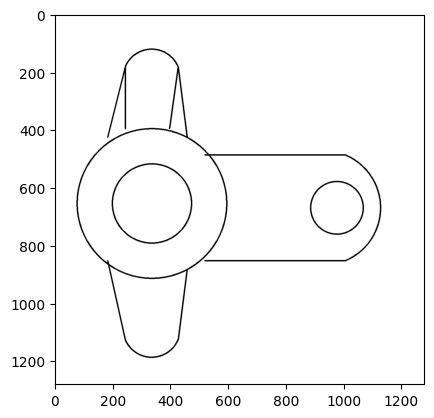

In [19]:
plt.imshow(data[3][-1].to_image())

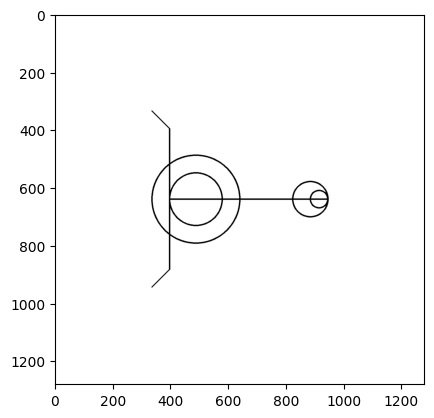

In [17]:
plt.imshow(output.design.to_image())

In [10]:
response = gpt4_agent.client.chat.completions.create(
            model="gpt-4o",
            messages=prompt,
            max_tokens=gpt4_agent.max_tokens,
            temperature=gpt4_agent.temperature,
            response_format={"type": "json_object"},
        )

In [12]:
json.loads(response.choices[0].message.content)["editing_actions"]

[{'action': 'add_circle', 'control_points': [[-10, 0], [-5, 0]]},
 {'action': 'add_circle', 'control_points': [[-10, 0], [-8, 0]]},
 {'action': 'add_line', 'control_points': [[-10, 5], [-8, 10]]},
 {'action': 'add_line', 'control_points': [[-10, -5], [-8, -10]]},
 {'action': 'add_line', 'control_points': [[-8, 10], [-6, 8]]},
 {'action': 'add_line', 'control_points': [[-8, -10], [-6, -8]]},
 {'action': 'add_line', 'control_points': [[-5, 0], [5, 0]]},
 {'action': 'add_circle', 'control_points': [[5, 0], [8, 0]]},
 {'action': 'add_circle', 'control_points': [[6, 0], [7, 0]]}]